In [137]:
import pandas as pd
import numpy as np
from scipy import stats, signal
from tqdm import trange, tqdm
from matplotlib.pyplot import *

%matplotlib inline

In [138]:
# figure styling
import seaborn as sns
sns.set(style='ticks', palette='colorblind')

rcParams['figure.figsize'] = (13,4.5)
rcParams['figure.dpi'] = 200

In [139]:
images = np.load('../data/stim.npy')

train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/sub.csv')

dd = np.load('../data/features.npz')
features = dict()
for k in dd.keys():
    features[k] = dd[k]

    
conv_train = np.load('../data/conv_train.npy').flat[0]
conv_test = np.load('../data/conv_test.npy').flat[0]

conv_features = dict()
for k in conv_train.keys():
    conv_features[k] = np.vstack([conv_test[k], conv_train[k]])

In [140]:
features.keys()

dict_keys(['raw', 'LAB', 'fourier', 'gabor', 'stats', 'stats_LAB'])

In [141]:
conv_features.keys()

dict_keys(['conv1', 'conv2', 'conv3', 'conv4', 'conv5'])

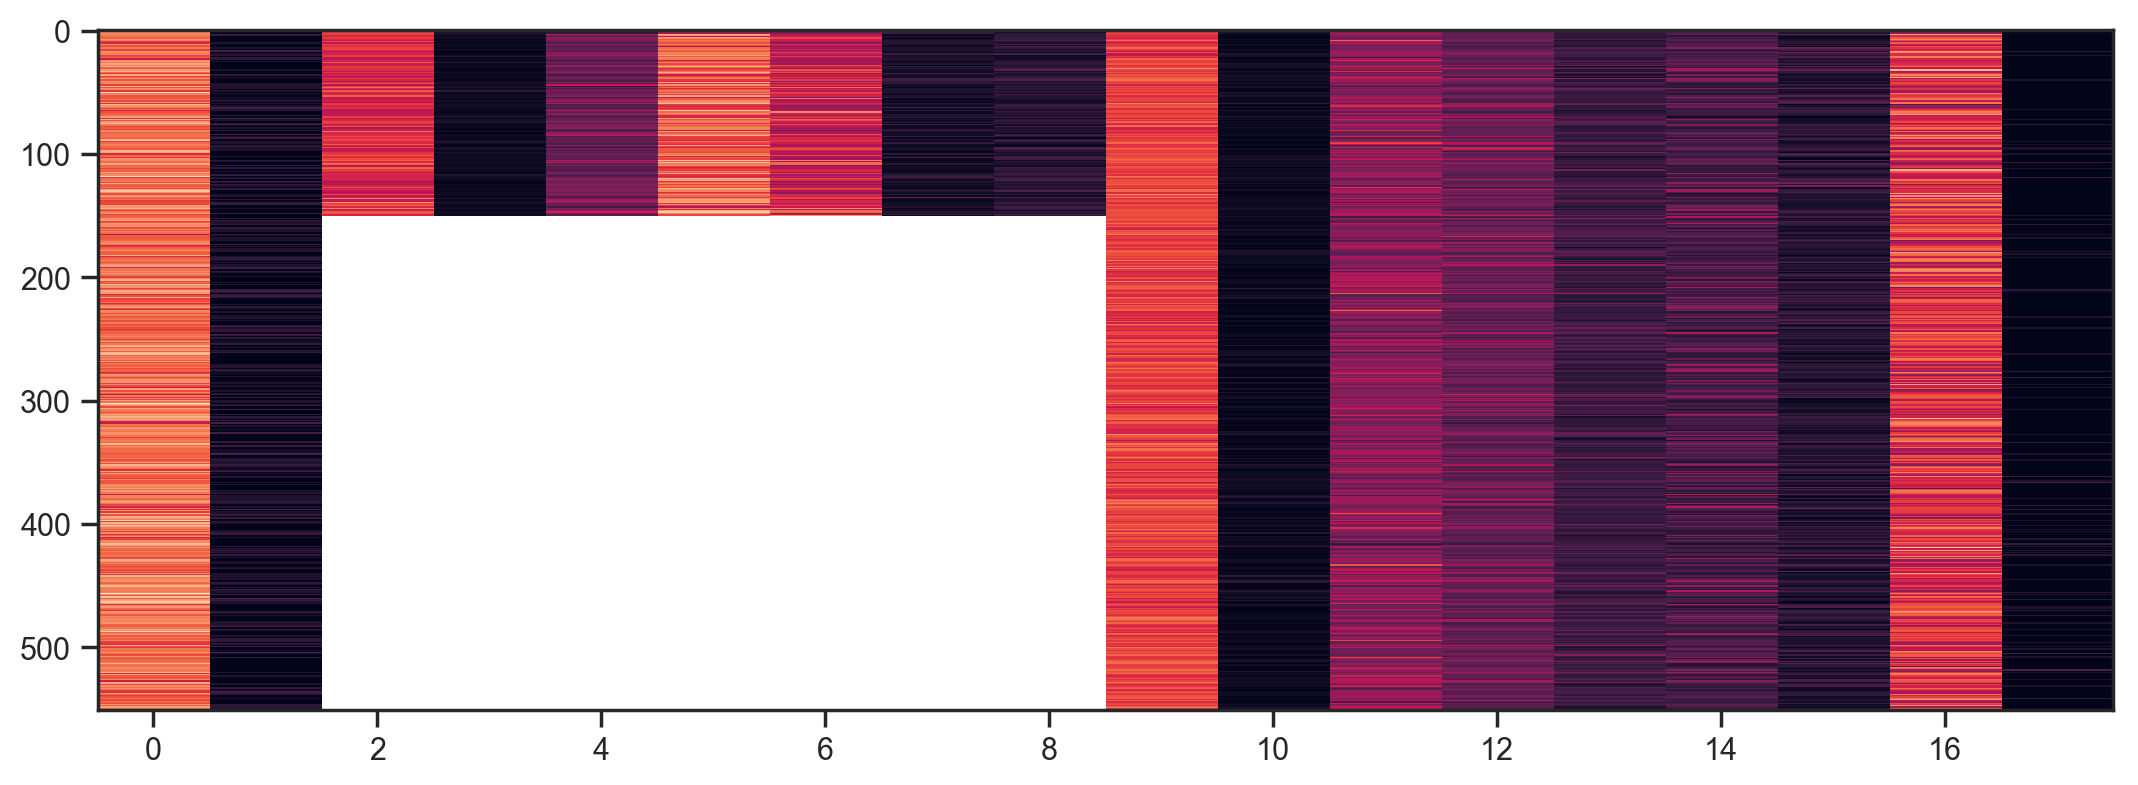

In [142]:
responses = np.array(train.iloc[:, 1:])

imshow(responses, aspect='auto')

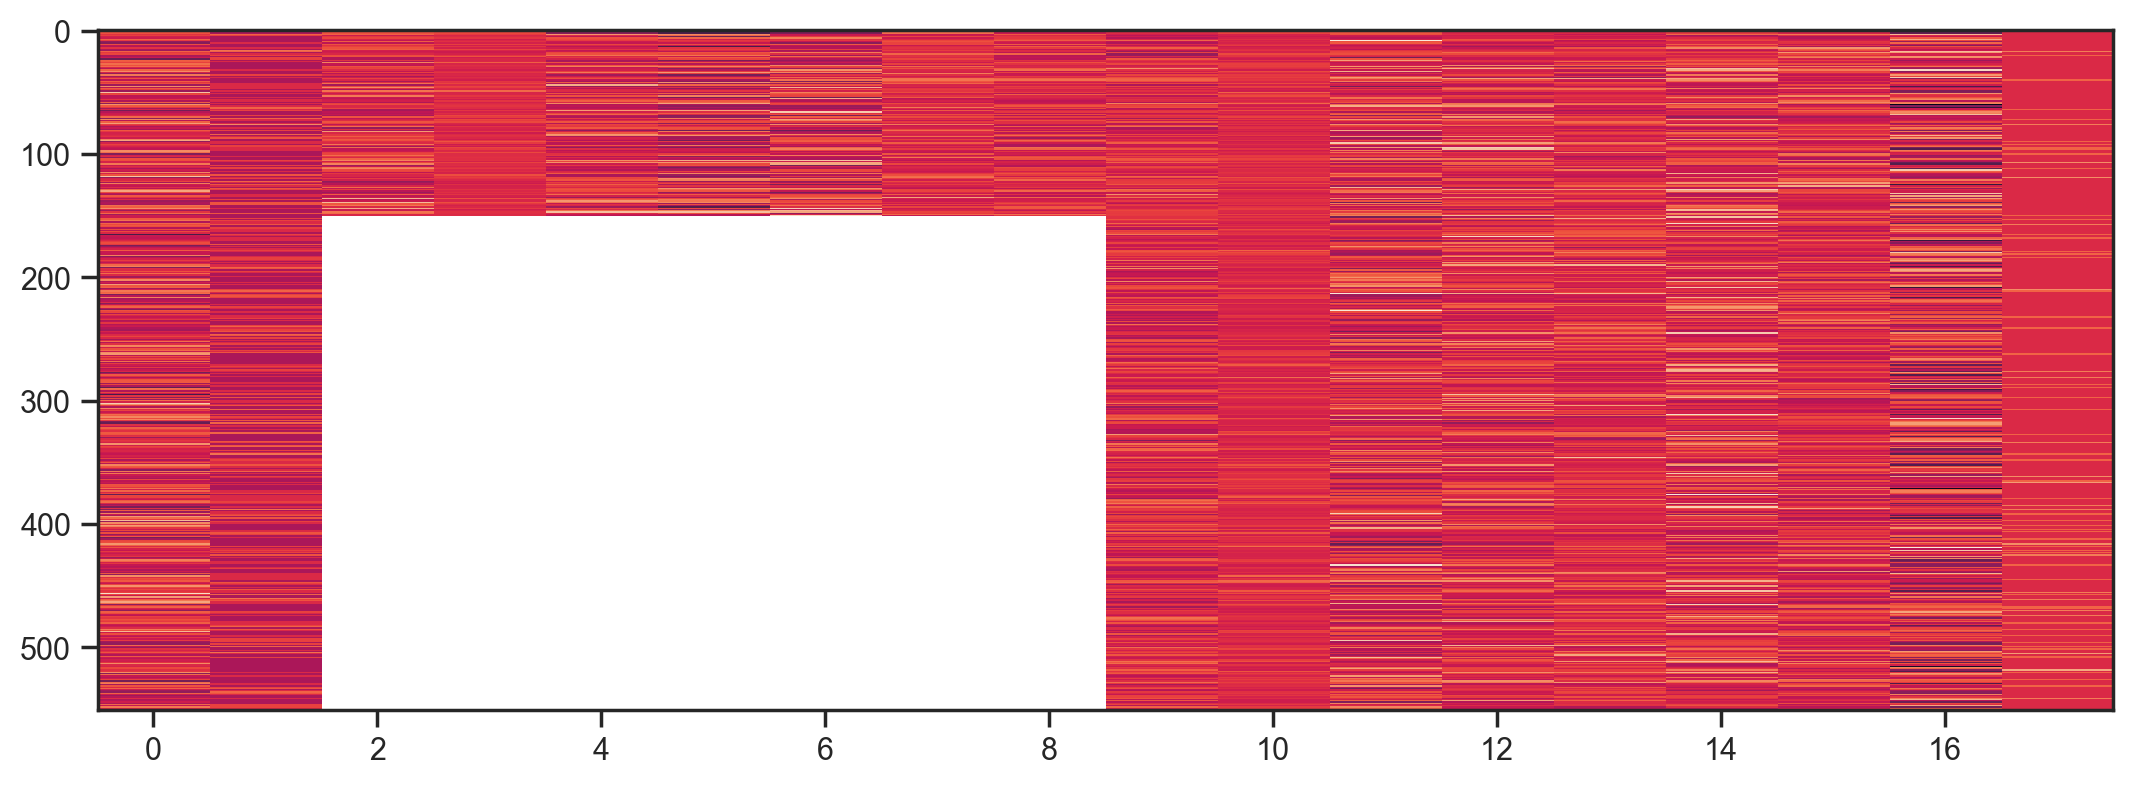

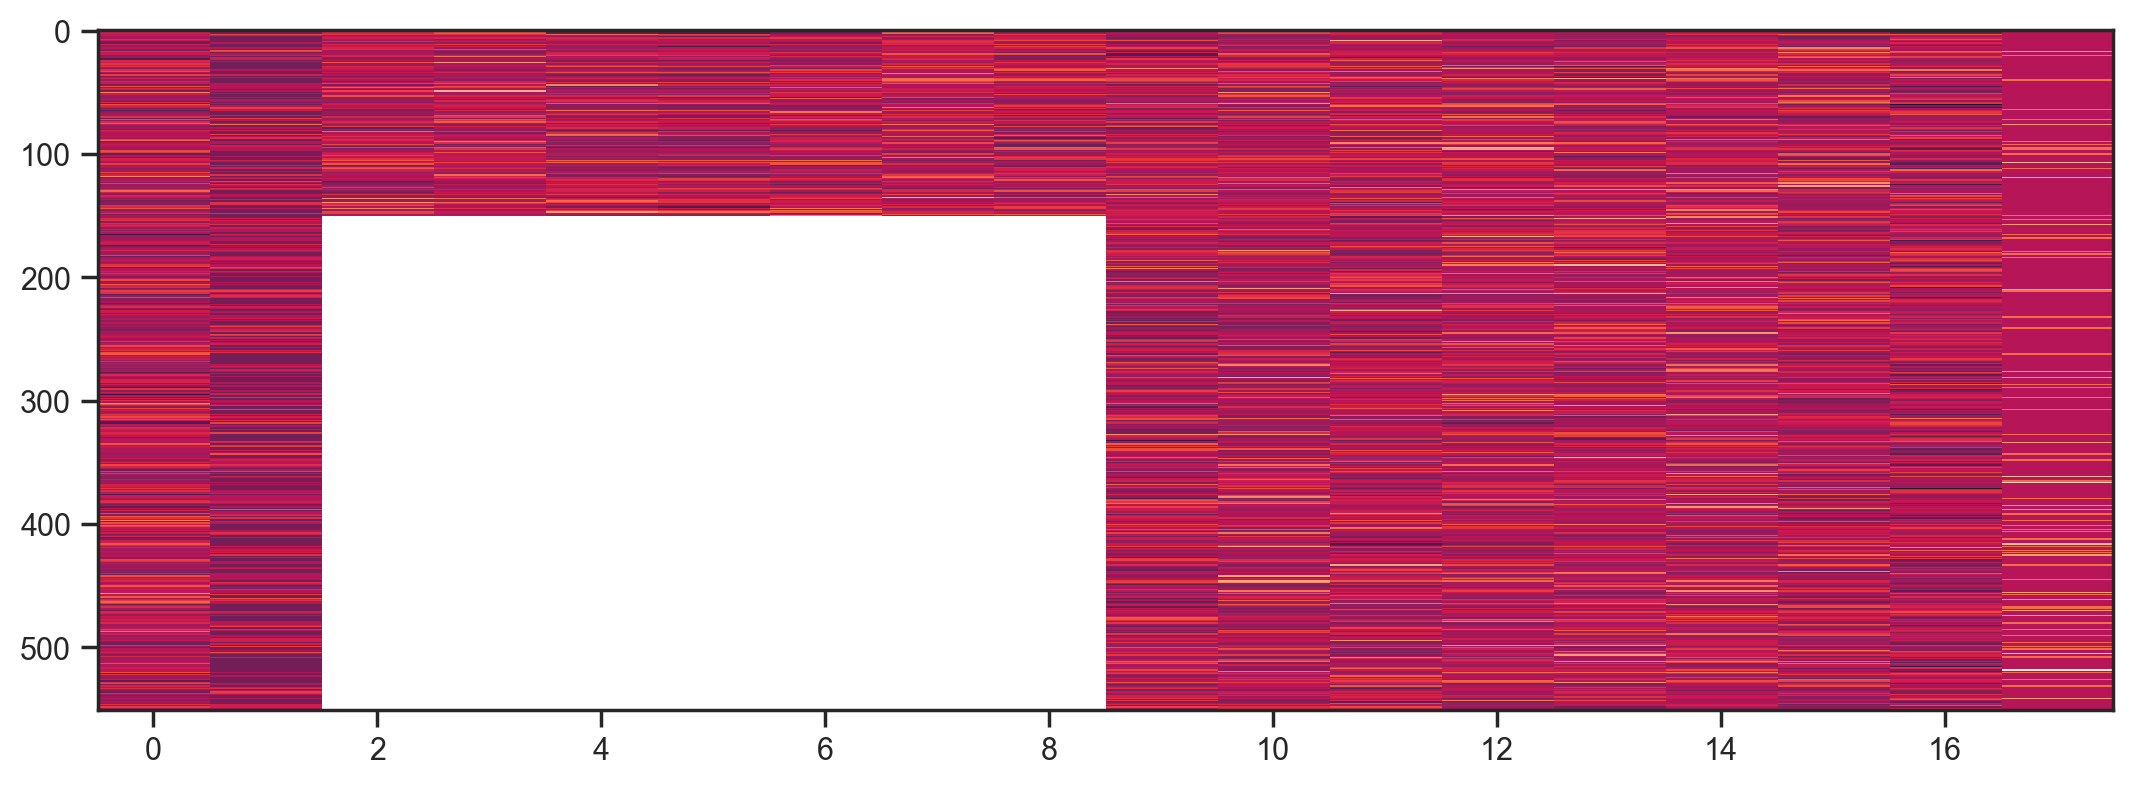

In [143]:
responses_demean = np.copy(responses)
responses_std = np.copy(responses)

means = []
stds = []

for r in range(responses.shape[1]):
    vals = responses[:, r]
    vs = vals[~np.isnan(vals)]
    responses_demean[:, r] = vals - np.median(vs)
    responses_std[:, r] = (vals - np.median(vs)) / np.std(vs)
    
    means.append(np.median(vs))
    stds.append(np.std(vs))
    
means = np.array(means)
stds = np.array(stds)
    
imshow(responses_demean, aspect='auto')

figure()
imshow(responses_std, aspect='auto')

Imputing row 1/551 with 0 missing, elapsed time: 0.059
Imputing row 101/551 with 0 missing, elapsed time: 0.060
Imputing row 201/551 with 7 missing, elapsed time: 0.067
Imputing row 301/551 with 7 missing, elapsed time: 0.076
Imputing row 401/551 with 7 missing, elapsed time: 0.085
Imputing row 501/551 with 7 missing, elapsed time: 0.097


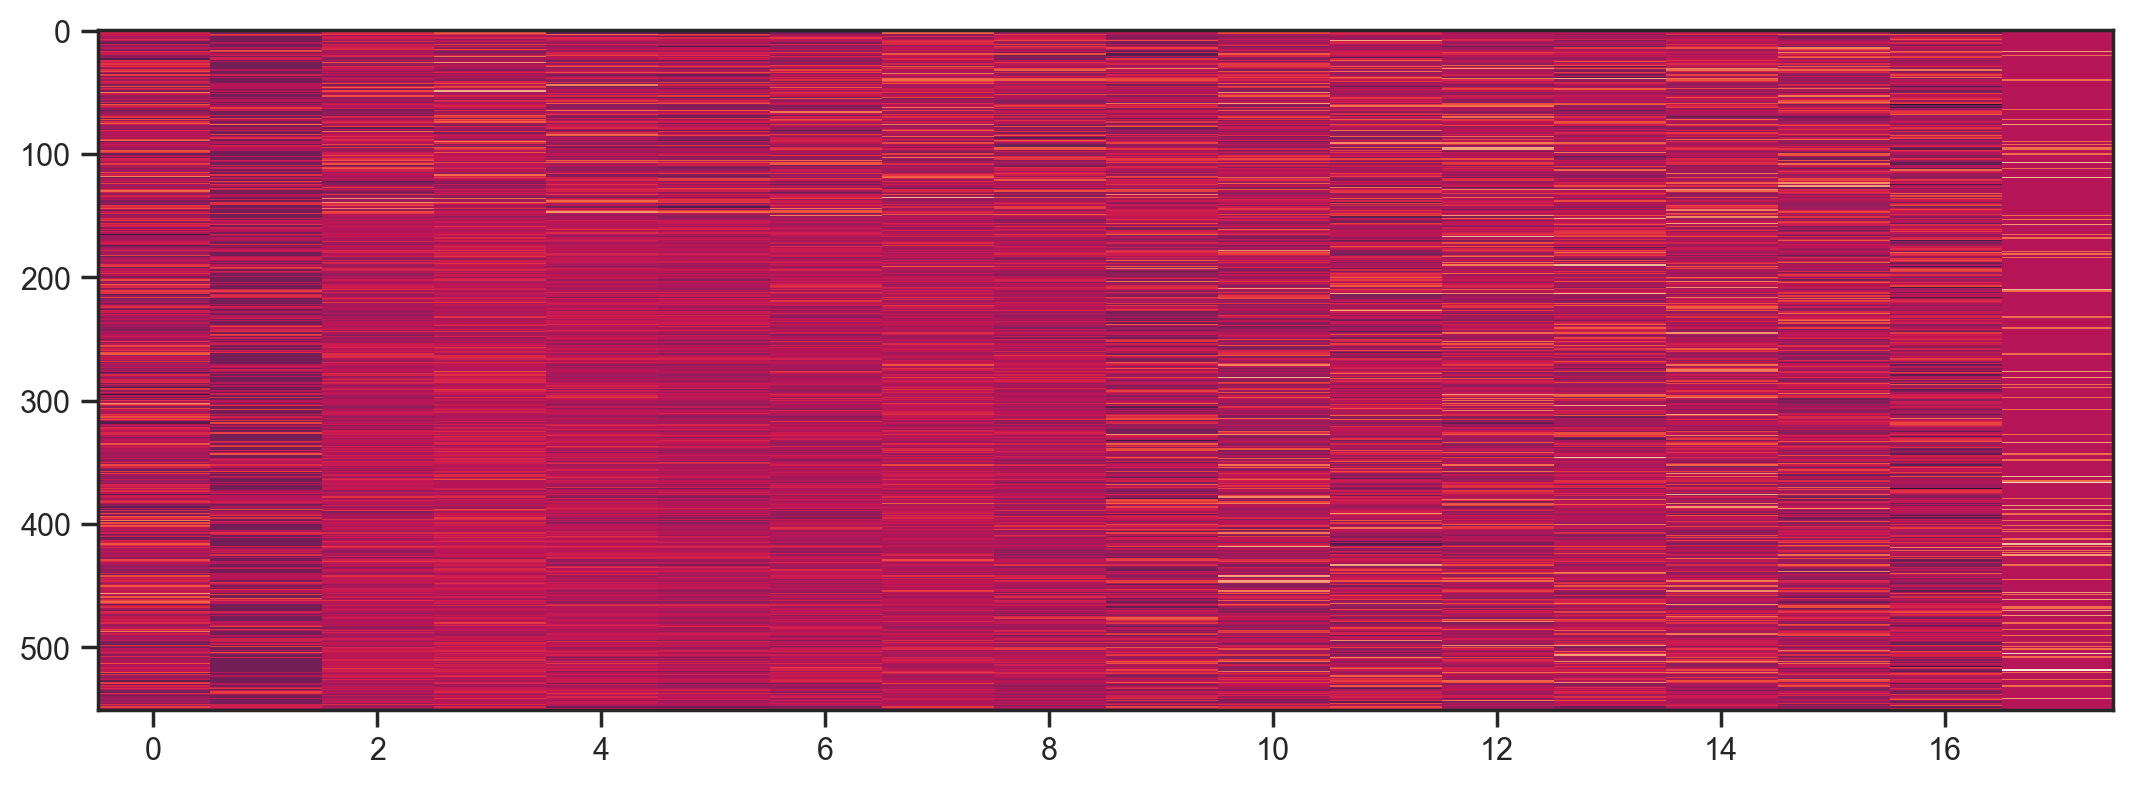

In [144]:
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler

responses_imputed = KNN(k=5).fit_transform(responses_std)
# responses_imputed = SoftImpute().fit_transform(responses_std)

imshow(responses_imputed, aspect='auto')

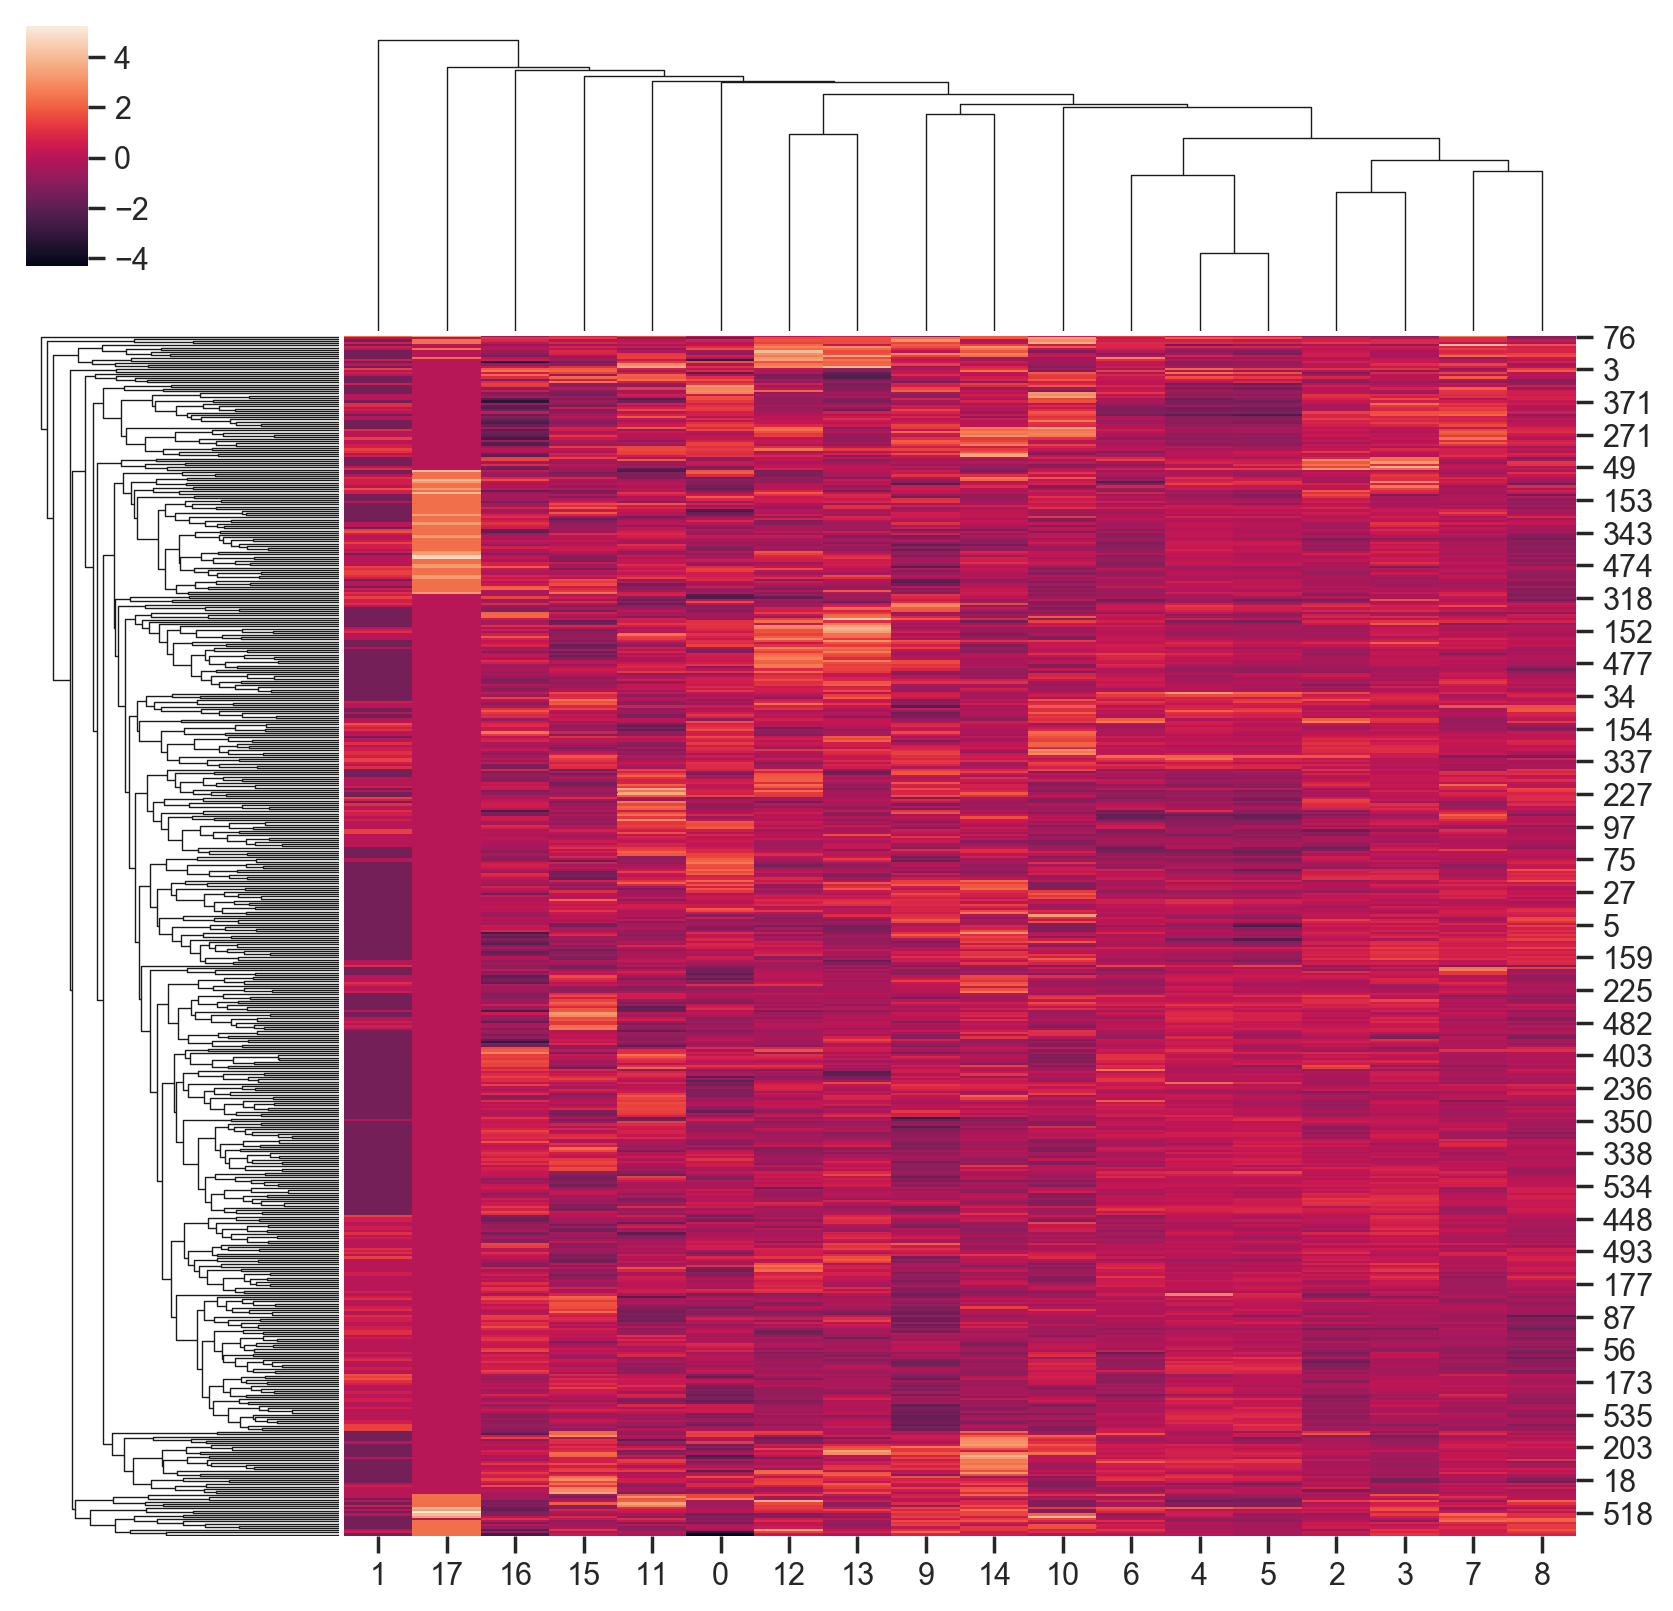

In [145]:
sns.clustermap(responses_imputed)

In [146]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics.scorer import make_scorer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor


import umap

In [147]:
conv_features.keys()

dict_keys(['conv1', 'conv2', 'conv3', 'conv4', 'conv5'])

In [148]:
pcs_lab = PCA(n_components=50).fit_transform(features['LAB'])
pcs_fourier = PCA(n_components=20).fit_transform(features['fourier'])
pcs_gabor = PCA(n_components=20).fit_transform(features['gabor'])

In [149]:
pcs_conv1 = PCA(n_components=30).fit_transform(conv_features['conv1'])
pcs_conv2 = PCA(n_components=20).fit_transform(conv_features['conv2'])
pcs_conv3 = PCA(n_components=20).fit_transform(conv_features['conv3'])
pcs_conv4 = PCA(n_components=20).fit_transform(conv_features['conv4'])
pcs_conv5 = PCA(n_components=10).fit_transform(conv_features['conv5'])


In [150]:
images_flat = images[:, 20:-20,20:-20].reshape(images.shape[0], -1)
# images_flat = images.reshape(images.shape[0], -1)
pcs_raw = PCA(n_components=50).fit_transform(images_flat)

embedding = umap.UMAP(metric='correlation', min_dist=1.0, n_components=50)
X_embed = embedding.fit_transform(images_flat)

In [151]:
# X_all = np.hstack([X_embed, features['stats'], pcs_lab, pcs_gabor])
# X_all = np.hstack([X_embed, features['stats'], pcs_conv4, pcs_conv5])
# X_all = np.hstack([X_embed, features['stats'], pcs_conv1, pcs_conv2, pcs_conv3, pcs_conv4, pcs_conv5])
# X_all = np.hstack([X_embed, features['stats'], pcs_conv3, pcs_conv4])
X_all = np.hstack([X_embed, features['stats'], features['stats_LAB'],
                   pcs_lab, pcs_conv1, pcs_conv4, pcs_conv5])

# X_all = np.hstack([conv_features['conv1'], conv_features['conv4'], conv_features['conv5']])

In [176]:
# model = Ridge(alpha=10000000)
# model = Lasso(alpha=2)
# model = RidgeCV()
model = ExtraTreesRegressor(max_depth=15, n_estimators=300)
# model = KNeighborsRegressor(n_neighbors=10)
# model = SVR('rbf')
# model = MLPRegressor(hidden_layer_sizes=(3,))

all_scores = []
for i in range(responses.shape[1]):
    vals = responses[:, i]
    good = ~np.isnan(vals)
    scores = cross_val_score(model, X_all[50:][good], vals[good], 
                             scoring=make_scorer(mean_squared_error), cv=3)
    print(i, np.mean(scores))
    all_scores.append(np.mean(scores))
    
print(np.mean(all_scores))
print(np.sqrt(np.mean(all_scores)))

0 0.878279392001991
1 0.4474426983138256
2 0.47684472074267586
3 0.06992914674292536
4 0.5864813547236475
5 1.0981640967291104
6 1.0232565911760305
7 0.22718743021559526
8 0.27763795806620933
9 0.2792125819342001
10 0.08777057828693392
11 0.6438410448190311
12 0.4710698209121131
13 0.33326616543866544
14 0.5130915275405751
15 0.32975026734506513
16 1.1796270705378933
17 0.200134630900211
0.5068326153570388
0.7119217761503288


In [177]:
new_test = test.copy()

for i in trange(responses.shape[1]):
    vals = responses[:, i]
    good = ~np.isnan(vals)
    model.fit(X_all[50:][good], vals[good])
    pred = model.predict(X_all[:50])
    new_test.iloc[:, i+1] = pred

100%|██████████| 18/18 [00:56<00:00,  3.14s/it]


In [178]:
new_test.to_csv('../data/output_umap_nnet.csv', index=False)

In [161]:
model = Ridge(alpha=1000)
# model = RidgeCV()
model = ExtraTreesRegressor(max_depth=5, n_estimators=100)
# model = KNeighborsRegressor(n_neighbors=100)

pca = PCA()
pca.fit(responses_imputed)
responses_pc = pca.fit_transform(responses_imputed)

all_scores = []
for i in range(responses_pc.shape[1]):
    vals = responses_pc[:, i]
    good = ~np.isnan(vals)
    scores = cross_val_score(model, X_all[50:][good], vals[good], 
                             scoring=make_scorer(r2_score))
    print(i, np.mean(scores))
    all_scores.append(np.mean(scores))
    
print(np.mean(all_scores))

0 0.506187898176075
1 0.2111584010254672
2 0.29981616077923423
3 0.07626216392626099
4 0.06355698173215825
5 0.06037718209246146
6 -0.038236935375365176
7 0.04996112992781417
8 0.07314391992783735
9 -0.07197032959099821
10 0.001036075092127516
11 -0.008522178958880411
12 0.027421058996154695
13 -0.07188182598470856
14 -0.04294542036755581
15 -0.027748969060679734
16 -0.03616724323325097
17 -0.04379577427946679
0.057091794156926966


In [156]:
responses_pc_pred = []

for i in range(responses_pc.shape[1]):
    vals = responses_pc[:, i]
    good = ~np.isnan(vals)
    model.fit(X_all[50:][good], vals[good])
    pred = model.predict(X_all[:50])
    responses_pc_pred.append(pred)
    
responses_pc_pred = np.array(responses_pc_pred).T

responses_pred_raw = pca.inverse_transform(responses_pc_pred)
responses_pred = responses_pred_raw * stds + means

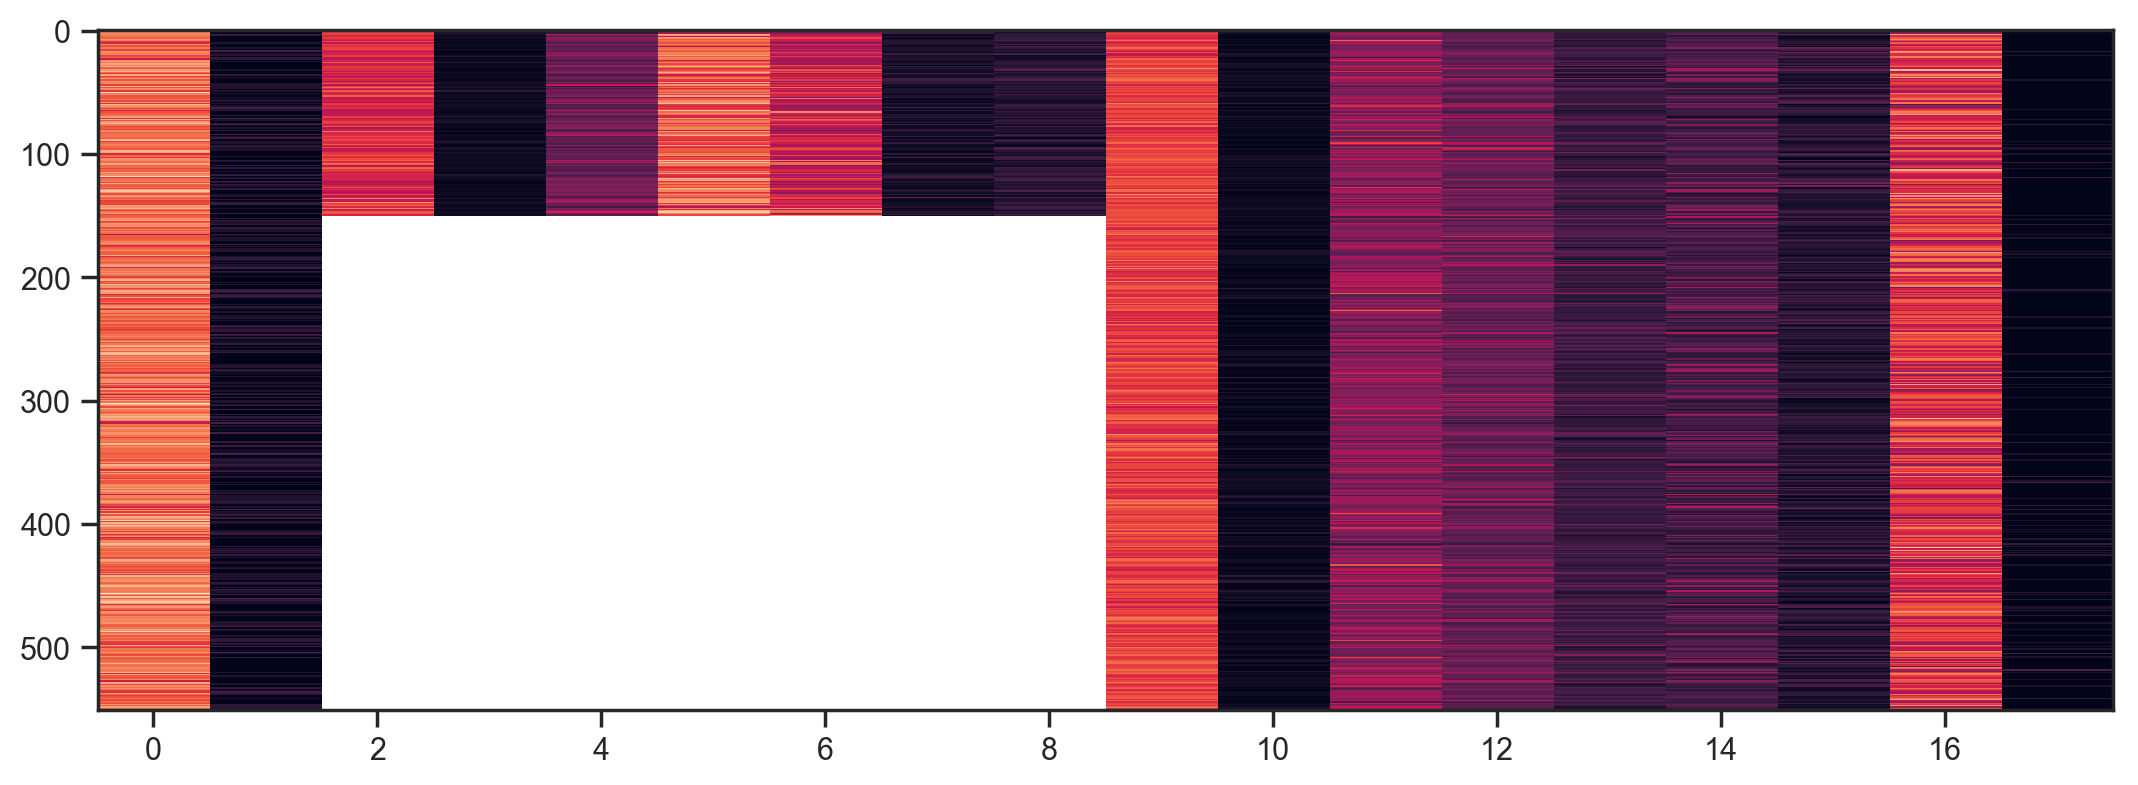

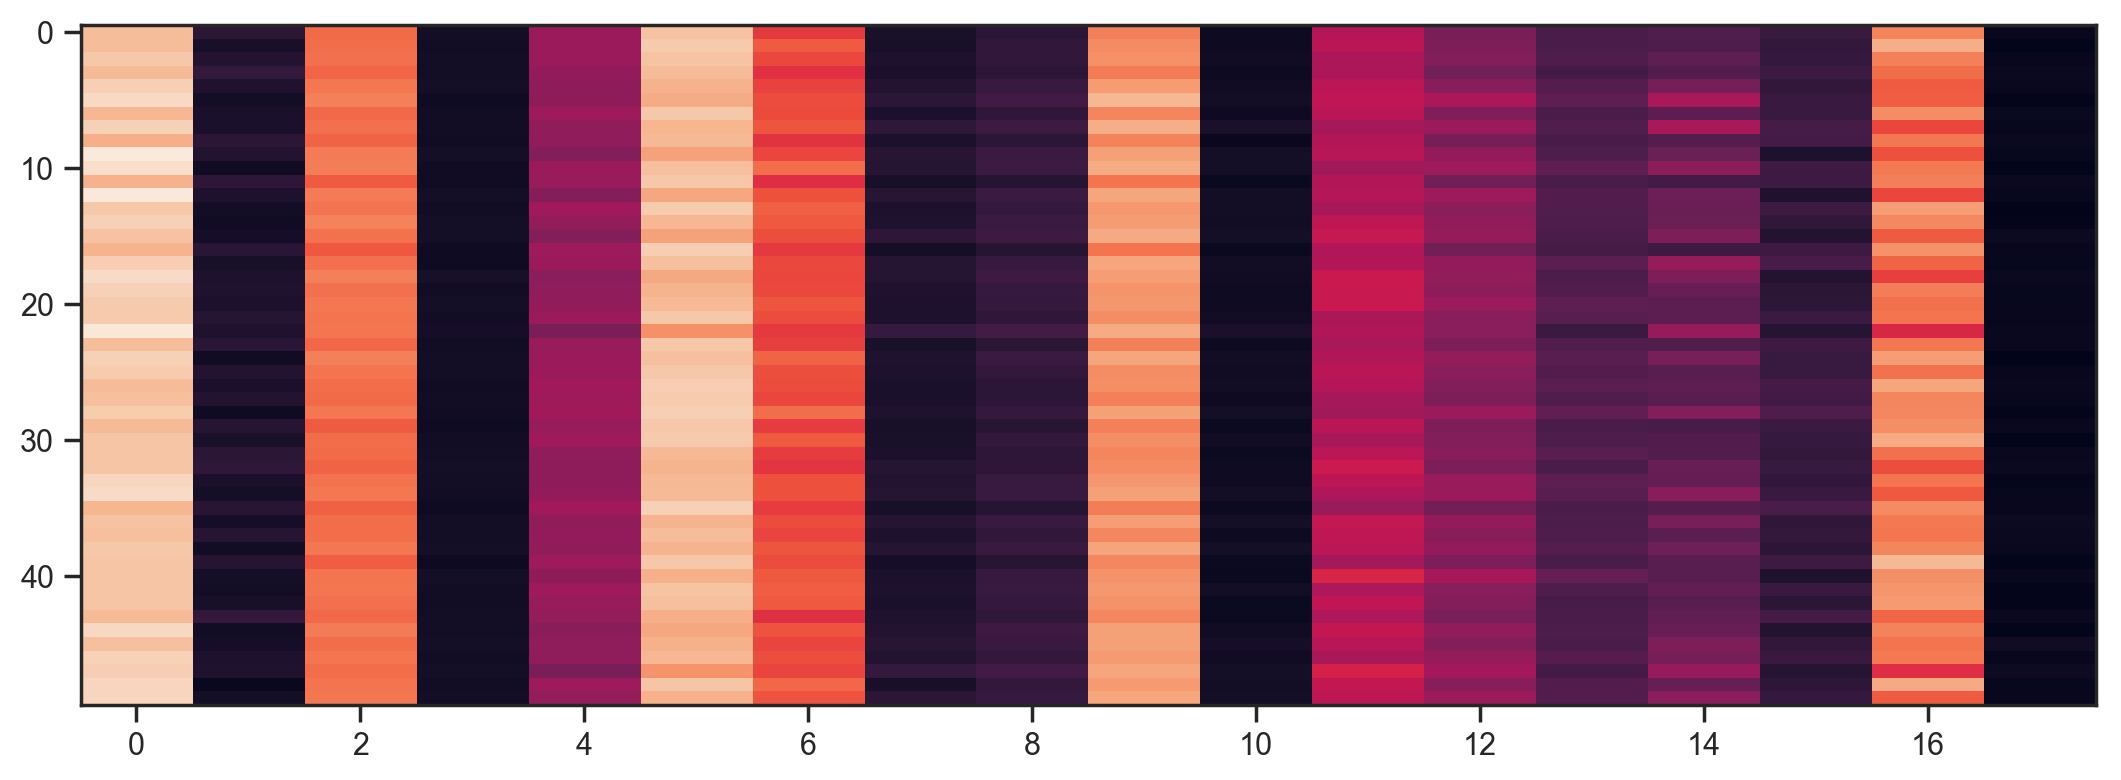

In [157]:
imshow(responses, aspect='auto')
figure()
imshow(responses_pred, aspect='auto')

In [158]:
new_test = test.copy()

for i in range(responses.shape[1]):
    new_test.iloc[:, i+1] = responses_pred[:, i]

In [159]:
new_test.to_csv('../data/output_umap_nnet_pca.csv', index=False)